In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
##https://www.kaggle.com/code/annastasy/anomaly-detection-credit-card-fraud
# Load the dataset
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
# Distribution of the target variable (fraud detection)
status_counts = df.Class.value_counts()
print(status_counts)

Class
0    284315
1       492
Name: count, dtype: int64


In [2]:
#特征转化标准化
# Feature names
features = df.columns[:-1]  # Excluding the target column
# Transforming skewed data
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values

D:\DeepLearning\Anaconda\envs\torch3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\DeepLearning\Anaconda\envs\torch3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# --- Isolation Forest (sklearn) ---
iso_forest = IsolationForest(contamination=0.05, random_state=101)
iso_preds = iso_forest.fit_predict(X_scaled)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

print("Isolation Forest Evaluation:")
print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

Isolation Forest Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.85      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9015054619225298


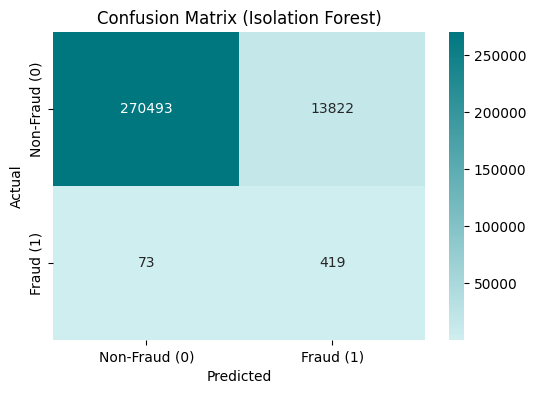

In [10]:
# Confusion Matrix
cm = confusion_matrix(y, iso_preds)
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#CFEEF0', '#00777F'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')
plt.title('Confusion Matrix (Isolation Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [11]:
# Now we need to calculate Card Precision@100
# 1. Sort samples by the anomaly score (or prediction) in descending order (anomalies first)
# 2. Select the top 100 samples (fraud detection)
anomaly_scores = iso_forest.decision_function(X_scaled)  # Get the anomaly score (lower score is more anomalous)
sorted_indices = np.argsort(anomaly_scores)  # Sort by anomaly score, ascending order

# Select top 100 samples with the lowest anomaly score
top_100_indices = sorted_indices[:100]

# 3. Calculate precision: how many of the top 100 are actual fraud (Class = 1)
y_top_100 = y[top_100_indices]  # True labels of the top 100 samples
precision_at_100 = np.mean(y_top_100 == 1)  # Fraction of fraud (Class = 1) in the top 100

print(f"Card Precision@100: {precision_at_100:.4f}")

Card Precision@100: 0.2300


In [12]:
# --- Autoencoder for Anomaly Detection
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        
        # Latent space
        self.latent = nn.Linear(8, 4)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
df_transformed = df.copy()
# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    reconstructed = autoencoder(X_train)
    loss = criterion(reconstructed, X_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
reconstructed = autoencoder(X_scaled_tensor)
mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)
autoen_preds = np.where(mse > threshold, 1, 0)

# Autoencoder evaluation
print("Autoencoder Evaluation:")
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)

Epoch [2/50], Loss: 1.0093
Epoch [4/50], Loss: 1.0091
Epoch [6/50], Loss: 1.0089
Epoch [8/50], Loss: 1.0088
Epoch [10/50], Loss: 1.0086
Epoch [12/50], Loss: 1.0084
Epoch [14/50], Loss: 1.0082
Epoch [16/50], Loss: 1.0081
Epoch [18/50], Loss: 1.0079
Epoch [20/50], Loss: 1.0077
Epoch [22/50], Loss: 1.0076
Epoch [24/50], Loss: 1.0074
Epoch [26/50], Loss: 1.0072
Epoch [28/50], Loss: 1.0071
Epoch [30/50], Loss: 1.0069
Epoch [32/50], Loss: 1.0068
Epoch [34/50], Loss: 1.0066
Epoch [36/50], Loss: 1.0064
Epoch [38/50], Loss: 1.0063
Epoch [40/50], Loss: 1.0061
Epoch [42/50], Loss: 1.0060
Epoch [44/50], Loss: 1.0058
Epoch [46/50], Loss: 1.0057
Epoch [48/50], Loss: 1.0055
Epoch [50/50], Loss: 1.0054
Autoencoder Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    284315
           1       0.02      0.90      0.03       492

    accuracy                           0.90    284807
   macro avg       0.51      0.90      0.49    284807
weighted

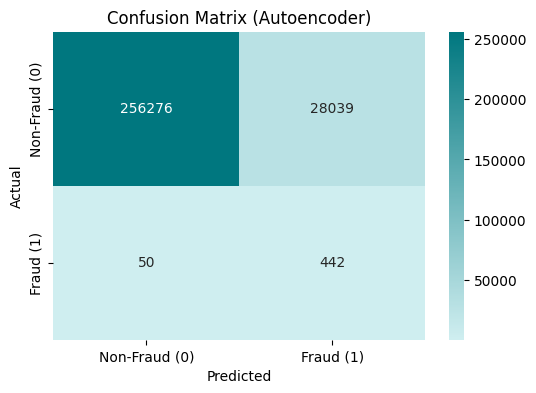

In [13]:
# Confusion Matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')
plt.title('Confusion Matrix (Autoencoder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [14]:
def card_precision_at_k(preds, y_true, k=100):
    """
    Calculate Card Precision at K, i.e., the fraction of relevant items
    (fraud samples) in the top K predictions (highest MSE).
    """
    # Get the indices of the top K largest MSE values
    top_k_indices = np.argsort(preds)[-k:]  # Indices of the top K MSE values (highest reconstruction errors)
    
    # Check how many of the top K are actual frauds (y_true == 1)
    relevant_count = np.sum(y_true[top_k_indices] == 1)  # Count how many of the top K are frauds
    
    # Calculate precision: number of frauds in top K / K
    return relevant_count / k

# Use the MSE values (reconstruction errors) from the autoencoder
pred_scores = mse  # The MSE values calculated during autoencoder evaluation

# --- Calculate Card Precision@100 ---
card_precision = card_precision_at_k(pred_scores, y, k=100)
print(f"Card Precision@100: {card_precision:.4f}")

Card Precision@100: 0.2500


In [13]:
#########################
#---------------------GELU--------------------------------

In [15]:
# --- Autoencoder for Anomaly Detection
class GELU(nn.Module):
    def __init__(self, init_sigma=1.0):  # Default sigma initialized to 3.0
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

# Define the Autoencoder with GELU activations
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            GELU(init_sigma=1.0),  # Use custom GELU
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            GELU(init_sigma=1.0),  # Use custom GELU
            nn.Linear(16, 8),
            GELU(init_sigma=1.0)   # Use custom GELU
        )
        
        # Latent space
        self.latent = nn.Linear(8, 4)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            GELU(init_sigma=1.0),  # Use custom GELU
            nn.Dropout(0.2),
            nn.Linear(8, 16),
            GELU(init_sigma=1.0),  # Use custom GELU
            nn.Linear(16, 32),
            GELU(init_sigma=1.0),  # Use custom GELU
            nn.Linear(32, input_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
df_transformed = df.copy()
# Training the Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    reconstructed = autoencoder(X_train)
    loss = criterion(reconstructed, X_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
reconstructed = autoencoder(X_scaled_tensor)
mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)
autoen_preds = np.where(mse > threshold, 1, 0)

# Autoencoder evaluation
print("Autoencoder Evaluation:")
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)

pred_scores = mse  # The MSE values calculated during autoencoder evaluation

# --- Calculate Card Precision@100 ---
card_precision = card_precision_at_k(pred_scores, y, k=100)
print(f"Card Precision@100: {card_precision:.4f}")

Epoch [10/50], Loss: 0.9972
Epoch [20/50], Loss: 0.9966
Epoch [30/50], Loss: 0.9961
Epoch [40/50], Loss: 0.9956
Epoch [50/50], Loss: 0.9951
Autoencoder Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    284315
           1       0.02      0.90      0.03       492

    accuracy                           0.90    284807
   macro avg       0.51      0.90      0.49    284807
weighted avg       1.00      0.90      0.95    284807

ROC AUC Score:  0.9008952661717673
Card Precision@100: 0.2600


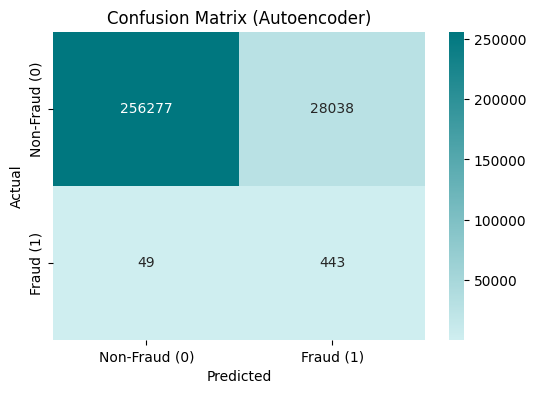

In [16]:
# Confusion Matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')
plt.title('Confusion Matrix (Autoencoder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import optuna
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Define the custom GELU activation function with learnable sigma
class GELU(nn.Module):
    def __init__(self, sigma):
        super(GELU, self).__init__()
        self.sigma = sigma

    def forward(self, input):
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp

# Define the Autoencoder with custom GELU activation layers
class Autoencoder(nn.Module):
    def __init__(self, input_dim, trial):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            GELU(sigma=trial.suggest_float('sigma_1', 0.01, 5.0)),  # Optimized sigma for layer 1
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            GELU(sigma=trial.suggest_float('sigma_2', 0.01, 5.0)),  # Optimized sigma for layer 2
            nn.Linear(16, 8),
            GELU(sigma=trial.suggest_float('sigma_3', 0.01, 5.0))   # Optimized sigma for layer 3
        )

        # Latent space
        self.latent = nn.Linear(8, 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            GELU(sigma=trial.suggest_float('sigma_4', 0.01, 5.0)),  # Optimized sigma for layer 4
            nn.Dropout(0.2),
            nn.Linear(8, 16),
            GELU(sigma=trial.suggest_float('sigma_5', 0.01, 5.0)),  # Optimized sigma for layer 5
            nn.Linear(16, 32),
            GELU(sigma=trial.suggest_float('sigma_6', 0.01, 5.0)),  # Optimized sigma for layer 6
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

# Function to calculate Card Precision@100
def card_precision_at_k(preds, y_true, k=100):
    top_k_indices = np.argsort(preds)[-k:]
    
    relevant_count = np.sum(y_true[top_k_indices] == 1)
    
    return relevant_count / k

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)
# Objective function for Optuna

best_model = None
best_model_state = None
best_target = float('-inf')  # 初始设为一个很大的值

def objective(trial):
    global best_model, best_model_state, best_target
    # Convert X_train to torch tensor and move to device (CPU or GPU)
    X_train_tensor = X_train
    
    # Initialize the model with trial-based sigma values
    autoencoder = Autoencoder(input_dim, trial).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

    # Training the Autoencoder
    num_epochs = 50
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed = autoencoder(X_train_tensor)
        loss = criterion(reconstructed, X_train_tensor)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Calculate reconstruction error
    autoencoder.eval()
    X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    reconstructed = autoencoder(X_scaled_tensor)
    mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

    # Set a threshold for anomaly detection
    threshold = np.percentile(mse, 90)
    autoen_preds = np.where(mse > threshold, 1, 0)

    roc_auc = roc_auc_score(y, autoen_preds)

    pred_scores = mse  # The MSE values calculated during autoencoder evaluation

    # --- Calculate Card Precision@100 ---
    card_precision = card_precision_at_k(pred_scores, y, k=100)

    target_value = roc_auc + card_precision
    print(roc_auc)
    print(card_precision)

    if target_value > best_target:
        best_target = target_value

        print("Updated Best Model!")

        cm = confusion_matrix(y, autoen_preds)
        print(f"Confusion Matrix:\n{cm}")

    # The objective is the sum of ROC AUC and Card Precision
    return target_value


# Set up Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Number of trials

# Print the best trial
print(f"Best trial: {study.best_trial}")

[I 2024-12-10 15:38:15,647] A new study created in memory with name: no-name-df1f7079-a36c-49b6-a591-a3c3dcf940b6


Epoch [10/50], Loss: 1.0001
Epoch [20/50], Loss: 0.9995
Epoch [30/50], Loss: 0.9989
Epoch [40/50], Loss: 0.9983


[I 2024-12-10 15:38:17,767] Trial 0 finished with value: 1.1508952661717673 and parameters: {'sigma_1': 4.323582549040235, 'sigma_2': 2.9781389829793197, 'sigma_3': 4.277083240018297, 'sigma_4': 3.2570547249170074, 'sigma_5': 0.37952510480396917, 'sigma_6': 2.0816055320841134}. Best is trial 0 with value: 1.1508952661717673.


Epoch [50/50], Loss: 0.9978
0.9008952661717673
0.25
Updated Best Model!
Confusion Matrix:
[[256277  28038]
 [    49    443]]
Epoch [10/50], Loss: 1.0038
Epoch [20/50], Loss: 1.0030
Epoch [30/50], Loss: 1.0023
Epoch [40/50], Loss: 1.0016


[I 2024-12-10 15:38:19,660] Trial 1 finished with value: 1.162931303722583 and parameters: {'sigma_1': 0.8952547031085127, 'sigma_2': 2.6233930396719747, 'sigma_3': 2.568767022545135, 'sigma_4': 1.091058896603169, 'sigma_5': 2.4596475007239067, 'sigma_6': 0.39681837470654746}. Best is trial 1 with value: 1.162931303722583.


Epoch [50/50], Loss: 1.0009
0.9029313037225829
0.26
Updated Best Model!
Confusion Matrix:
[[256279  28036]
 [    47    445]]
Epoch [10/50], Loss: 1.0012
Epoch [20/50], Loss: 1.0004
Epoch [30/50], Loss: 0.9998
Epoch [40/50], Loss: 0.9991


[I 2024-12-10 15:38:21,569] Trial 2 finished with value: 1.1598772473963597 and parameters: {'sigma_1': 4.380413949417047, 'sigma_2': 4.053911812751716, 'sigma_3': 0.6572271965931673, 'sigma_4': 2.638760828349077, 'sigma_5': 1.3164511956433347, 'sigma_6': 3.398261452090586}. Best is trial 1 with value: 1.162931303722583.


Epoch [50/50], Loss: 0.9985
0.8998772473963595
0.26
Epoch [10/50], Loss: 1.0029
Epoch [20/50], Loss: 1.0022
Epoch [30/50], Loss: 1.0015
Epoch [40/50], Loss: 1.0008


[I 2024-12-10 15:38:23,520] Trial 3 finished with value: 1.1437691347439123 and parameters: {'sigma_1': 3.346090654796297, 'sigma_2': 2.405571213770834, 'sigma_3': 3.301223199198687, 'sigma_4': 3.1609380821516213, 'sigma_5': 2.7053042430691447, 'sigma_6': 1.774511573882392}. Best is trial 1 with value: 1.162931303722583.


Epoch [50/50], Loss: 1.0002
0.8937691347439124
0.25
Epoch [10/50], Loss: 1.0064
Epoch [20/50], Loss: 1.0053
Epoch [30/50], Loss: 1.0043
Epoch [40/50], Loss: 1.0034


[I 2024-12-10 15:38:25,370] Trial 4 finished with value: 1.1729313037225828 and parameters: {'sigma_1': 3.5483974060483745, 'sigma_2': 2.8385470588190547, 'sigma_3': 0.05390841858532132, 'sigma_4': 4.475796253206557, 'sigma_5': 1.7067679778705105, 'sigma_6': 0.2580915007458533}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0025
0.9029313037225829
0.27
Updated Best Model!
Confusion Matrix:
[[256279  28036]
 [    47    445]]
Epoch [10/50], Loss: 0.9985
Epoch [20/50], Loss: 0.9979
Epoch [30/50], Loss: 0.9973
Epoch [40/50], Loss: 0.9968


[I 2024-12-10 15:38:27,289] Trial 5 finished with value: 1.1598772473963597 and parameters: {'sigma_1': 4.49466540981247, 'sigma_2': 4.286650693227429, 'sigma_3': 2.150806590882448, 'sigma_4': 0.7664020813324591, 'sigma_5': 0.9245627945713463, 'sigma_6': 3.4577997872393254}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 0.9962
0.8998772473963595
0.26
Epoch [10/50], Loss: 0.9995
Epoch [20/50], Loss: 0.9989
Epoch [30/50], Loss: 0.9982
Epoch [40/50], Loss: 0.9976


[I 2024-12-10 15:38:29,248] Trial 6 finished with value: 1.1529313037225828 and parameters: {'sigma_1': 1.1250219659432543, 'sigma_2': 3.5831495724776614, 'sigma_3': 4.420990773559764, 'sigma_4': 0.39372593833139136, 'sigma_5': 3.5750898954671206, 'sigma_6': 4.266935197668333}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 0.9971
0.9029313037225829
0.25
Epoch [10/50], Loss: 0.9999
Epoch [20/50], Loss: 0.9992
Epoch [30/50], Loss: 0.9986
Epoch [40/50], Loss: 0.9979


[I 2024-12-10 15:38:31,155] Trial 7 finished with value: 1.1608952661717673 and parameters: {'sigma_1': 0.8190176307832547, 'sigma_2': 1.554472544146648, 'sigma_3': 4.571150843088767, 'sigma_4': 0.12459133116607385, 'sigma_5': 0.029128341939756212, 'sigma_6': 4.196708275869798}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 0.9974
0.9008952661717673
0.26
Epoch [10/50], Loss: 1.0019
Epoch [20/50], Loss: 1.0010
Epoch [30/50], Loss: 1.0002
Epoch [40/50], Loss: 0.9994


[I 2024-12-10 15:38:32,992] Trial 8 finished with value: 1.1729313037225828 and parameters: {'sigma_1': 1.4045405315713937, 'sigma_2': 3.266823381319363, 'sigma_3': 4.983281145580973, 'sigma_4': 4.392700608553288, 'sigma_5': 4.529845651029005, 'sigma_6': 0.08197894954823118}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 0.9987
0.9029313037225829
0.27
Epoch [10/50], Loss: 1.0036
Epoch [20/50], Loss: 1.0027
Epoch [30/50], Loss: 1.0020
Epoch [40/50], Loss: 1.0012


[I 2024-12-10 15:38:34,806] Trial 9 finished with value: 1.1519132849471752 and parameters: {'sigma_1': 4.147723048348782, 'sigma_2': 1.8824613401695298, 'sigma_3': 0.1686922118539206, 'sigma_4': 0.5661411391328903, 'sigma_5': 3.9092285319579543, 'sigma_6': 4.042535264217789}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0005
0.9019132849471752
0.25
Epoch [10/50], Loss: 1.0044
Epoch [20/50], Loss: 1.0037
Epoch [30/50], Loss: 1.0029
Epoch [40/50], Loss: 1.0022


[I 2024-12-10 15:38:36,682] Trial 10 finished with value: 1.165805172294728 and parameters: {'sigma_1': 2.4606130116538285, 'sigma_2': 1.085556278277168, 'sigma_3': 1.1693190196442547, 'sigma_4': 4.505583722319168, 'sigma_5': 1.9248484484346475, 'sigma_6': 1.2027256312720245}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0016
0.895805172294728
0.27
Epoch [10/50], Loss: 1.0090
Epoch [20/50], Loss: 1.0079
Epoch [30/50], Loss: 1.0068
Epoch [40/50], Loss: 1.0058


[I 2024-12-10 15:38:38,609] Trial 11 finished with value: 1.1619132849471752 and parameters: {'sigma_1': 2.104287090450984, 'sigma_2': 0.2033256898437572, 'sigma_3': 1.7764744433881632, 'sigma_4': 4.877892223668052, 'sigma_5': 4.995244639140243, 'sigma_6': 0.12854707982293723}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0049
0.9019132849471752
0.26
Epoch [10/50], Loss: 0.9987
Epoch [20/50], Loss: 0.9981
Epoch [30/50], Loss: 0.9975
Epoch [40/50], Loss: 0.9970


[I 2024-12-10 15:38:40,485] Trial 12 finished with value: 1.162931303722583 and parameters: {'sigma_1': 1.7618544525598865, 'sigma_2': 3.4765266222412086, 'sigma_3': 3.286646412723637, 'sigma_4': 4.109042114231396, 'sigma_5': 4.71605630679025, 'sigma_6': 1.1688952936179764}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 0.9965
0.9029313037225829
0.26
Epoch [10/50], Loss: 1.0044
Epoch [20/50], Loss: 1.0035
Epoch [30/50], Loss: 1.0027
Epoch [40/50], Loss: 1.0019


[I 2024-12-10 15:38:42,366] Trial 13 finished with value: 1.1619132849471752 and parameters: {'sigma_1': 0.02914073861912403, 'sigma_2': 3.2144663282300625, 'sigma_3': 3.476953854990864, 'sigma_4': 3.7509538979855845, 'sigma_5': 3.2561819648109434, 'sigma_6': 0.757147524193861}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0011
0.9019132849471752
0.26
Epoch [10/50], Loss: 1.0035
Epoch [20/50], Loss: 1.0028
Epoch [30/50], Loss: 1.0022
Epoch [40/50], Loss: 1.0016


[I 2024-12-10 15:38:44,275] Trial 14 finished with value: 1.1619132849471752 and parameters: {'sigma_1': 3.2860152638489923, 'sigma_2': 4.604805791128836, 'sigma_3': 1.1878629902905873, 'sigma_4': 1.7760916175284285, 'sigma_5': 1.6407257480691126, 'sigma_6': 2.8235499126126813}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0010
0.9019132849471752
0.26
Epoch [10/50], Loss: 1.0096
Epoch [20/50], Loss: 1.0085
Epoch [30/50], Loss: 1.0075
Epoch [40/50], Loss: 1.0065


[I 2024-12-10 15:38:46,118] Trial 15 finished with value: 1.1688592286209518 and parameters: {'sigma_1': 3.2621622661533265, 'sigma_2': 2.127079417365291, 'sigma_3': 2.7726892566976358, 'sigma_4': 4.853363368011699, 'sigma_5': 4.284692154834501, 'sigma_6': 0.12050344365058961}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0056
0.8988592286209517
0.27
Epoch [10/50], Loss: 1.0027
Epoch [20/50], Loss: 1.0020
Epoch [30/50], Loss: 1.0013
Epoch [40/50], Loss: 1.0006


[I 2024-12-10 15:38:47,988] Trial 16 finished with value: 1.1719132849471752 and parameters: {'sigma_1': 4.987445886159216, 'sigma_2': 3.775409543682156, 'sigma_3': 3.9768362598548235, 'sigma_4': 3.8241011996981236, 'sigma_5': 2.424999577357538, 'sigma_6': 4.975011729660967}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0000
0.9019132849471752
0.27
Epoch [10/50], Loss: 0.9987
Epoch [20/50], Loss: 0.9981
Epoch [30/50], Loss: 0.9975
Epoch [40/50], Loss: 0.9969


[I 2024-12-10 15:38:49,830] Trial 17 finished with value: 1.165805172294728 and parameters: {'sigma_1': 1.5691084460449471, 'sigma_2': 4.965331727949254, 'sigma_3': 4.896875014990432, 'sigma_4': 2.353432982758831, 'sigma_5': 2.9415171323297113, 'sigma_6': 0.9325299134500971}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 0.9964
0.895805172294728
0.27
Epoch [10/50], Loss: 1.0046
Epoch [20/50], Loss: 1.0038
Epoch [30/50], Loss: 1.0030
Epoch [40/50], Loss: 1.0022


[I 2024-12-10 15:38:51,727] Trial 18 finished with value: 1.1488592286209518 and parameters: {'sigma_1': 2.82666457802426, 'sigma_2': 2.852443011614958, 'sigma_3': 1.3572187081502192, 'sigma_4': 4.246386346260932, 'sigma_5': 1.9948040862470788, 'sigma_6': 1.7783997551780728}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 1.0015
0.8988592286209517
0.25
Epoch [10/50], Loss: 1.0022
Epoch [20/50], Loss: 1.0015
Epoch [30/50], Loss: 1.0009
Epoch [40/50], Loss: 1.0003


[I 2024-12-10 15:38:53,646] Trial 19 finished with value: 1.1619132849471752 and parameters: {'sigma_1': 0.11200082845438963, 'sigma_2': 1.1498011220213629, 'sigma_3': 0.6195101022490858, 'sigma_4': 3.467714870878054, 'sigma_5': 0.835243388826762, 'sigma_6': 0.6741600669156753}. Best is trial 4 with value: 1.1729313037225828.


Epoch [50/50], Loss: 0.9997
0.9019132849471752
0.26
Best trial: FrozenTrial(number=4, state=TrialState.COMPLETE, values=[1.1729313037225828], datetime_start=datetime.datetime(2024, 12, 10, 15, 38, 23, 520539), datetime_complete=datetime.datetime(2024, 12, 10, 15, 38, 25, 370687), params={'sigma_1': 3.5483974060483745, 'sigma_2': 2.8385470588190547, 'sigma_3': 0.05390841858532132, 'sigma_4': 4.475796253206557, 'sigma_5': 1.7067679778705105, 'sigma_6': 0.2580915007458533}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'sigma_1': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_2': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_3': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_4': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_5': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_6': FloatDistribution(high=5.0, log=False, low=0.01, step=None)}, trial_id=4, value=No

In [23]:
############################
#--------SiLU---------------------------

In [24]:
class SiLU(nn.Module):  # 激活函数含噪声参数
    def __init__(self,sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        temp = input * torch.sigmoid(input / self.sigma) # 前向传播
        return temp

# Define the Autoencoder with custom GELU activation layers
class Autoencoder(nn.Module):
    def __init__(self, input_dim, trial):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            SiLU(sigma=trial.suggest_float('sigma_1', 0.01, 5.0)),  # Optimized sigma for layer 1
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            SiLU(sigma=trial.suggest_float('sigma_2', 0.01, 5.0)),  # Optimized sigma for layer 2
            nn.Linear(16, 8),
            SiLU(sigma=trial.suggest_float('sigma_3', 0.01, 5.0))   # Optimized sigma for layer 3
        )

        # Latent space
        self.latent = nn.Linear(8, 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            SiLU(sigma=trial.suggest_float('sigma_4', 0.01, 5.0)),  # Optimized sigma for layer 4
            nn.Dropout(0.2),
            nn.Linear(8, 16),
            SiLU(sigma=trial.suggest_float('sigma_5', 0.01, 5.0)),  # Optimized sigma for layer 5
            nn.Linear(16, 32),
            SiLU(sigma=trial.suggest_float('sigma_6', 0.01, 5.0)),  # Optimized sigma for layer 6
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

# Function to calculate Card Precision@100
def card_precision_at_k(preds, y_true, k=100):
    top_k_indices = np.argsort(preds)[-k:]
    
    relevant_count = np.sum(y_true[top_k_indices] == 1)
    
    return relevant_count / k

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)
# Objective function for Optuna

best_model = None
best_model_state = None
best_target = float('-inf')  # 初始设为一个很大的值

def objective(trial):
    global best_model, best_model_state, best_target
    # Convert X_train to torch tensor and move to device (CPU or GPU)
    X_train_tensor = X_train
    
    # Initialize the model with trial-based sigma values
    autoencoder = Autoencoder(input_dim, trial).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

    # Training the Autoencoder
    num_epochs = 50
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed = autoencoder(X_train_tensor)
        loss = criterion(reconstructed, X_train_tensor)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Calculate reconstruction error
    autoencoder.eval()
    X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    reconstructed = autoencoder(X_scaled_tensor)
    mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

    # Set a threshold for anomaly detection
    threshold = np.percentile(mse, 90)
    autoen_preds = np.where(mse > threshold, 1, 0)

    roc_auc = roc_auc_score(y, autoen_preds)

    pred_scores = mse  # The MSE values calculated during autoencoder evaluation

    # --- Calculate Card Precision@100 ---
    card_precision = card_precision_at_k(pred_scores, y, k=100)

    target_value = roc_auc + card_precision
    print(roc_auc)
    print(card_precision)

    if target_value > best_target:
        best_target = target_value

        print("Updated Best Model!")

        cm = confusion_matrix(y, autoen_preds)
        print(f"Confusion Matrix:\n{cm}")

    # The objective is the sum of ROC AUC and Card Precision
    return target_value


# Set up Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Number of trials

# Print the best trial
print(f"Best trial: {study.best_trial}")

[I 2024-12-10 15:47:00,792] A new study created in memory with name: no-name-af774752-383a-4aa9-8129-35b1a231b439


Epoch [10/50], Loss: 1.0008
Epoch [20/50], Loss: 1.0000
Epoch [30/50], Loss: 0.9993
Epoch [40/50], Loss: 0.9986


[I 2024-12-10 15:47:02,986] Trial 0 finished with value: 1.1608952661717673 and parameters: {'sigma_1': 3.8589451997014343, 'sigma_2': 0.6366100975742811, 'sigma_3': 0.23255635878842731, 'sigma_4': 0.6140695470982138, 'sigma_5': 0.8538029531706773, 'sigma_6': 2.2615249924657608}. Best is trial 0 with value: 1.1608952661717673.


Epoch [50/50], Loss: 0.9980
0.9008952661717673
0.26
Updated Best Model!
Confusion Matrix:
[[256277  28038]
 [    49    443]]
Epoch [10/50], Loss: 0.9987
Epoch [20/50], Loss: 0.9980
Epoch [30/50], Loss: 0.9974
Epoch [40/50], Loss: 0.9968


[I 2024-12-10 15:47:04,366] Trial 1 finished with value: 1.1598772473963597 and parameters: {'sigma_1': 1.2775882367382112, 'sigma_2': 4.021577272936855, 'sigma_3': 3.8983170906035536, 'sigma_4': 3.385687934505288, 'sigma_5': 3.566044439925867, 'sigma_6': 0.20641510183329398}. Best is trial 0 with value: 1.1608952661717673.


Epoch [50/50], Loss: 0.9963
0.8998772473963595
0.26
Epoch [10/50], Loss: 1.0045
Epoch [20/50], Loss: 1.0037
Epoch [30/50], Loss: 1.0030
Epoch [40/50], Loss: 1.0022


[I 2024-12-10 15:47:05,739] Trial 2 finished with value: 1.1437691347439123 and parameters: {'sigma_1': 1.1058864349474098, 'sigma_2': 0.21448153323754646, 'sigma_3': 3.268979629721009, 'sigma_4': 3.929208990123839, 'sigma_5': 3.239298126322887, 'sigma_6': 4.533926252716378}. Best is trial 0 with value: 1.1608952661717673.


Epoch [50/50], Loss: 1.0016
0.8937691347439124
0.25
Epoch [10/50], Loss: 0.9999
Epoch [20/50], Loss: 0.9992
Epoch [30/50], Loss: 0.9986
Epoch [40/50], Loss: 0.9980


[I 2024-12-10 15:47:07,105] Trial 3 finished with value: 1.1519132849471752 and parameters: {'sigma_1': 0.16471836040923696, 'sigma_2': 4.185866389162565, 'sigma_3': 3.727640145163909, 'sigma_4': 2.0060435246570827, 'sigma_5': 3.6127851844666035, 'sigma_6': 2.6774034430051525}. Best is trial 0 with value: 1.1608952661717673.


Epoch [50/50], Loss: 0.9975
0.9019132849471752
0.25
Epoch [10/50], Loss: 1.0050
Epoch [20/50], Loss: 1.0042
Epoch [30/50], Loss: 1.0034
Epoch [40/50], Loss: 1.0027


[I 2024-12-10 15:47:08,511] Trial 4 finished with value: 1.1819132849471752 and parameters: {'sigma_1': 2.36769136752505, 'sigma_2': 1.903668858916201, 'sigma_3': 1.249471268055059, 'sigma_4': 1.69545229841489, 'sigma_5': 3.825302963663427, 'sigma_6': 3.778333202961361}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 1.0020
0.9019132849471752
0.28
Updated Best Model!
Confusion Matrix:
[[256278  28037]
 [    48    444]]
Epoch [10/50], Loss: 1.0044
Epoch [20/50], Loss: 1.0036
Epoch [30/50], Loss: 1.0029
Epoch [40/50], Loss: 1.0022


[I 2024-12-10 15:47:09,888] Trial 5 finished with value: 1.1698772473963595 and parameters: {'sigma_1': 1.5320282537542964, 'sigma_2': 1.7330969246092813, 'sigma_3': 1.017910070684895, 'sigma_4': 0.41632932784876703, 'sigma_5': 2.8475450053063383, 'sigma_6': 4.595226796694766}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 1.0015
0.8998772473963595
0.27
Epoch [10/50], Loss: 1.0015
Epoch [20/50], Loss: 1.0009
Epoch [30/50], Loss: 1.0002
Epoch [40/50], Loss: 0.9996


[I 2024-12-10 15:47:11,259] Trial 6 finished with value: 1.162931303722583 and parameters: {'sigma_1': 2.1603670733504896, 'sigma_2': 4.272863062325414, 'sigma_3': 4.042349270075164, 'sigma_4': 3.429754443123532, 'sigma_5': 3.762290075373843, 'sigma_6': 3.3624994973818527}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9990
0.9029313037225829
0.26
Epoch [10/50], Loss: 1.0011
Epoch [20/50], Loss: 1.0004
Epoch [30/50], Loss: 0.9997
Epoch [40/50], Loss: 0.9991


[I 2024-12-10 15:47:12,627] Trial 7 finished with value: 1.1568231910701359 and parameters: {'sigma_1': 3.0203287730141013, 'sigma_2': 1.9125985255368163, 'sigma_3': 1.047630203889066, 'sigma_4': 2.371856639398125, 'sigma_5': 2.058717023173298, 'sigma_6': 1.4827712443354304}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9985
0.896823191070136
0.26
Epoch [10/50], Loss: 1.0037
Epoch [20/50], Loss: 1.0029
Epoch [30/50], Loss: 1.0021
Epoch [40/50], Loss: 1.0014


[I 2024-12-10 15:47:14,025] Trial 8 finished with value: 1.1588592286209516 and parameters: {'sigma_1': 1.3039415362195625, 'sigma_2': 1.9727327494504594, 'sigma_3': 0.5742272043530636, 'sigma_4': 0.39388932780396696, 'sigma_5': 3.1747873515725678, 'sigma_6': 4.250981166055977}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 1.0006
0.8988592286209517
0.26
Epoch [10/50], Loss: 1.0033
Epoch [20/50], Loss: 1.0025
Epoch [30/50], Loss: 1.0018
Epoch [40/50], Loss: 1.0011


[I 2024-12-10 15:47:15,400] Trial 9 finished with value: 1.1578412098455437 and parameters: {'sigma_1': 0.5592686547625447, 'sigma_2': 0.05016648275011203, 'sigma_3': 4.738172628161374, 'sigma_4': 2.688032997062558, 'sigma_5': 0.960191917920058, 'sigma_6': 3.199200668567924}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 1.0004
0.8978412098455437
0.26
Epoch [10/50], Loss: 1.0057
Epoch [20/50], Loss: 1.0048
Epoch [30/50], Loss: 1.0040
Epoch [40/50], Loss: 1.0032


[I 2024-12-10 15:47:16,792] Trial 10 finished with value: 1.1619132849471752 and parameters: {'sigma_1': 4.975852221810182, 'sigma_2': 3.0090405653078647, 'sigma_3': 1.9243611754297776, 'sigma_4': 1.5702849502738718, 'sigma_5': 4.884622535619381, 'sigma_6': 0.7986677672269604}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 1.0025
0.9019132849471752
0.26
Epoch [10/50], Loss: 1.0026
Epoch [20/50], Loss: 1.0018
Epoch [30/50], Loss: 1.0011
Epoch [40/50], Loss: 1.0004


[I 2024-12-10 15:47:18,195] Trial 11 finished with value: 1.1598772473963597 and parameters: {'sigma_1': 2.4165712023576456, 'sigma_2': 1.4592984924743408, 'sigma_3': 1.608309545474642, 'sigma_4': 1.185493163433229, 'sigma_5': 2.128602008058369, 'sigma_6': 4.760773371364629}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9997
0.8998772473963595
0.26
Epoch [10/50], Loss: 0.9996
Epoch [20/50], Loss: 0.9990
Epoch [30/50], Loss: 0.9984
Epoch [40/50], Loss: 0.9979


[I 2024-12-10 15:47:19,599] Trial 12 finished with value: 1.146823191070136 and parameters: {'sigma_1': 3.2253079201011845, 'sigma_2': 2.7746792522019508, 'sigma_3': 2.3641939306226263, 'sigma_4': 4.798522956589565, 'sigma_5': 4.5765041202338335, 'sigma_6': 3.803313906277831}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9974
0.896823191070136
0.25
Epoch [10/50], Loss: 1.0021
Epoch [20/50], Loss: 1.0013
Epoch [30/50], Loss: 1.0007
Epoch [40/50], Loss: 1.0000


[I 2024-12-10 15:47:21,014] Trial 13 finished with value: 1.1508952661717673 and parameters: {'sigma_1': 1.8714803038670829, 'sigma_2': 1.125820305056121, 'sigma_3': 1.2720147766243544, 'sigma_4': 0.03707387430944148, 'sigma_5': 2.469218717849555, 'sigma_6': 4.004918296474533}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9994
0.9008952661717673
0.25
Epoch [10/50], Loss: 0.9984
Epoch [20/50], Loss: 0.9978
Epoch [30/50], Loss: 0.9973
Epoch [40/50], Loss: 0.9969


[I 2024-12-10 15:47:22,427] Trial 14 finished with value: 1.1598772473963597 and parameters: {'sigma_1': 3.1022221858857906, 'sigma_2': 3.3601740743197377, 'sigma_3': 0.8041991633562838, 'sigma_4': 1.0436597696312553, 'sigma_5': 1.636677455163433, 'sigma_6': 4.964629027235462}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9964
0.8998772473963595
0.26
Epoch [10/50], Loss: 0.9992
Epoch [20/50], Loss: 0.9986
Epoch [30/50], Loss: 0.9980
Epoch [40/50], Loss: 0.9974


[I 2024-12-10 15:47:23,830] Trial 15 finished with value: 1.1619132849471752 and parameters: {'sigma_1': 4.093062217794065, 'sigma_2': 2.0797699135280276, 'sigma_3': 2.65040578958554, 'sigma_4': 1.6987984884003535, 'sigma_5': 4.116682653902661, 'sigma_6': 3.4585979480801994}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9969
0.9019132849471752
0.26
Epoch [10/50], Loss: 1.0017
Epoch [20/50], Loss: 1.0009
Epoch [30/50], Loss: 1.0002
Epoch [40/50], Loss: 0.9996


[I 2024-12-10 15:47:25,240] Trial 16 finished with value: 1.1698772473963595 and parameters: {'sigma_1': 1.759072622803806, 'sigma_2': 4.996587323975426, 'sigma_3': 1.9915151106575575, 'sigma_4': 0.8641398074156434, 'sigma_5': 0.1669671196970537, 'sigma_6': 2.526921054868854}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9989
0.8998772473963595
0.27
Epoch [10/50], Loss: 1.0004
Epoch [20/50], Loss: 0.9997
Epoch [30/50], Loss: 0.9991
Epoch [40/50], Loss: 0.9985


[I 2024-12-10 15:47:26,629] Trial 17 finished with value: 1.1708952661717673 and parameters: {'sigma_1': 2.6365671690984924, 'sigma_2': 1.4755693194671409, 'sigma_3': 0.17573014876898096, 'sigma_4': 0.19769643325959077, 'sigma_5': 2.8708679538481543, 'sigma_6': 4.183426831946275}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9979
0.9008952661717673
0.27
Epoch [10/50], Loss: 1.0002
Epoch [20/50], Loss: 0.9995
Epoch [30/50], Loss: 0.9988
Epoch [40/50], Loss: 0.9981


[I 2024-12-10 15:47:28,050] Trial 18 finished with value: 1.1568267082957484 and parameters: {'sigma_1': 2.581244852868557, 'sigma_2': 0.91812628819667, 'sigma_3': 0.15902992886659728, 'sigma_4': 2.7466837157600503, 'sigma_5': 4.338220238716995, 'sigma_6': 3.016600927257585}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9975
0.8968267082957484
0.26
Epoch [10/50], Loss: 1.0016
Epoch [20/50], Loss: 1.0008
Epoch [30/50], Loss: 1.0000
Epoch [40/50], Loss: 0.9993


[I 2024-12-10 15:47:29,462] Trial 19 finished with value: 1.162931303722583 and parameters: {'sigma_1': 3.6094185699464356, 'sigma_2': 2.5472104009479013, 'sigma_3': 0.4583280081119969, 'sigma_4': 1.422342371903859, 'sigma_5': 2.782439885844185, 'sigma_6': 1.8166002328466218}. Best is trial 4 with value: 1.1819132849471752.


Epoch [50/50], Loss: 0.9987
0.9029313037225829
0.26
Best trial: FrozenTrial(number=4, state=TrialState.COMPLETE, values=[1.1819132849471752], datetime_start=datetime.datetime(2024, 12, 10, 15, 47, 7, 121192), datetime_complete=datetime.datetime(2024, 12, 10, 15, 47, 8, 511728), params={'sigma_1': 2.36769136752505, 'sigma_2': 1.903668858916201, 'sigma_3': 1.249471268055059, 'sigma_4': 1.69545229841489, 'sigma_5': 3.825302963663427, 'sigma_6': 3.778333202961361}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'sigma_1': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_2': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_3': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_4': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_5': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_6': FloatDistribution(high=5.0, log=False, low=0.01, step=None)}, trial_id=4, value=None)
